# Wrangle and Analyze Data of a Twitter Account


## Table of Contents
- [0. Introduction](#intro)
- [1. Gather data](#gather)
- [2. Assess data](#assess)
- [3. Clean data](#clean)


<a id='gather'></a>
## 0. Introduction

This project is an analysis of correlation between the Covid-19 cases and the political environment of different countries. Goal is to find answers or at least indicators to questions like: 
- Did the countries which had more success in containing the amount of Covid-19 cases something in common? 
- Is there a correlation in  Gross domestic product, Human Development Index or political ideology with the amount of Covid-19 cases of the country.

Main goal of this project is to generate a comprehensive exploratory and explanatory data analysis of the gathered data. The data analysis process is distributed over three ipynb-files: gather_clean_Covid19.ipynb, exploration_Covid19.ipynb and slide_deck_Covid19.ipynb.

Firstly, as part of gather_clean_Covid19.ipynb data is gathered from different sources: The Covid-19 data of this project is retrieved via programmatically downloaded csv-files from the GitHub repository [Covid-19](https://github.com/CSSEGISandData/COVID-19) and additional data about countries is retrieved via the wikipedia API. Secondly, the data from the different sources is visually and programmatically assessed to be cleaned.
The exploratory and explanatory data analysis of the gathered data is performed in exploration_Covid19.ipynb. Finally the findings are presented in slide_deck_Covid19.ipynb.

In [1]:
# Import necessary libraries
import numpy as np
import pandas as pd
from datetime import date
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
import os # to work with local directory
import re
sns.set()

In [18]:
import wptools
import json # to create json file from python dictionary
import time # for timer 


In [22]:
# Query for every tweet id in enhanced twitter archive and save tweet-information in json-format to 'tweet_json.txt'
             
country_jsons = {}
county_id_errors = []
start = time.time()
count = 0


with open('country_json.txt', 'w') as outfile:
    
    for country in df_Countries['Country/Region']:
        count +=1
        try:
            # Query API for data of wikipedia article
            article = wptools.page(country).get_parse()
            infobox = article.data['infobox']
            # Measure elapsed time
            mid_s = time.time()
            # Print id and time elapsed
            print(str(count) + str(mid_s - start) )
            # Write json of tweet to 'tweet_json.txt'
            json.dump(infobox, outfile)
            # New line
            outfile.write("\n")

        # Not best practice to catch all exceptions but fine for this short script
        except Exception as error:
            mid_f = time.time()
            print(str(count) + str(mid_f - start) + str(error))
            # Gather ids of id's without status
            tweet_id_errors.append([count, str(tweet_id)])
            
    end = time.time()
    print(end - start)

en.wikipedia.org (parse) US
United States (en) data
{
  infobox: <dict(92)> conventional_long_name, common_name, image_f...
  iwlinks: <list(10)> https://commons.wikimedia.org/wiki/Atlas_of_...
  pageid: 3434750
  parsetree: <str(553748)> <root><template><title>pp-move-indef</t...
  requests: <list(1)> parse
  title: United States
  wikibase: Q30
  wikidata_url: https://www.wikidata.org/wiki/Q30
  wikitext: <str(402400)> {{pp-move-indef}}{{pp-semi-indef|small=y...
}
en.wikipedia.org (parse) Germany


119.97451400756836


Germany (en) data
{
  infobox: <dict(68)> conventional_long_name, common_name, native_...
  iwlinks: <list(13)> https://commons.wikimedia.org/wiki/Special:S...
  pageid: 11867
  parsetree: <str(215512)> <root><template><title>about</title><pa...
  requests: <list(1)> parse
  title: Germany
  wikibase: Q183
  wikidata_url: https://www.wikidata.org/wiki/Q183
  wikitext: <str(170690)> {{about|the country|other uses|Germany (...
}
en.wikipedia.org (parse) France


230.557862997055054


France (en) data
{
  infobox: <dict(93)> conventional_long_name, common_name, native_...
  iwlinks: <list(11)> https://commons.wikimedia.org/wiki/Atlas_of_...
  pageid: 5843419
  parsetree: <str(385775)> <root><template><title>Redirect</title>...
  requests: <list(1)> parse
  title: France
  wikibase: Q142
  wikidata_url: https://www.wikidata.org/wiki/Q142
  wikitext: <str(319303)> {{Redirect|La France|other uses of "La F...
}
en.wikipedia.org (parse) Belgium


341.429368019104004


Belgium (en) data
{
  infobox: <dict(71)> conventional_long_name, native_name, common_...
  iwlinks: <list(12)> https://commons.wikimedia.org/wiki/Atlas_of_...
  pageid: 3343
  parsetree: <str(237566)> <root><template><title>short descriptio...
  requests: <list(1)> parse
  title: Belgium
  wikibase: Q31
  wikidata_url: https://www.wikidata.org/wiki/Q31
  wikitext: <str(183801)> {{short description|Country in Western E...
}
en.wikipedia.org (parse) Netherlands


461.956069231033325


Netherlands (en) data
{
  infobox: <dict(95)> conventional_long_name, native_name, common_...
  iwlinks: <list(16)> https://commons.wikimedia.org/wiki/Atlas_of_...
  pageid: 21148
  parsetree: <str(330565)> <root><template lineStart="1"><title>ab...
  requests: <list(1)> parse
  title: Netherlands
  wikibase: Q55
  wikidata_url: https://www.wikidata.org/wiki/Q55
  wikitext: <str(251629)> {{about|the constituent country|the sove...
}
en.wikipedia.org (parse) Switzerland


571.08044219017029


Switzerland (en) data
{
  infobox: <dict(73)> conventional_long_name, common_name, native_...
  iwlinks: <list(10)> https://commons.wikimedia.org/wiki/Special:S...
  pageid: 26748
  parsetree: <str(261705)> <root><template><title>about</title><pa...
  requests: <list(1)> parse
  title: Switzerland
  wikibase: Q39
  wikidata_url: https://www.wikidata.org/wiki/Q39
  wikitext: <str(211296)> {{about|the sovereign state}}{{pp-semi-i...
}
en.wikipedia.org (parse) Italy


682.53980207443237


Italy (en) data
{
  infobox: <dict(83)> conventional_long_name, common_name, native_...
  iwlinks: <list(17)> https://commons.wikimedia.org/wiki/Atlas_of_...
  pageid: 14532
  parsetree: <str(410905)> <root><template><title>hatnote</title><...
  requests: <list(1)> parse
  title: Italy
  wikibase: Q38
  wikidata_url: https://www.wikidata.org/wiki/Q38
  wikitext: <str(334577)> {{hatnote|For other uses, see [[Italy (d...
}
en.wikipedia.org (parse) Spain


791.08354210853577


Spain (en) data
{
  infobox: <dict(86)> conventional_long_name, native_name, common_...
  iwlinks: <list(10)> https://commons.wikimedia.org/wiki/Atlas_of_...
  pageid: 26667
  parsetree: <str(313262)> <root><template><title>about</title><pa...
  requests: <list(1)> parse
  title: Spain
  wikibase: Q29
  wikidata_url: https://www.wikidata.org/wiki/Q29
  wikitext: <str(257676)> {{about|the country}}{{Redirect|España}}...
}
en.wikipedia.org (parse) United Kingdom


899.30159592628479


United Kingdom (en) data
{
  infobox: <dict(90)> common_name, linking_name, conventional_long...
  iwlinks: <list(10)> https://commons.wikimedia.org/wiki/Atlas_of_...
  pageid: 31717
  parsetree: <str(413024)> <root><template><title>About-distinguis...
  requests: <list(1)> parse
  title: United Kingdom
  wikibase: Q145
  wikidata_url: https://www.wikidata.org/wiki/Q145
  wikitext: <str(332165)> {{About-distinguish2|the country|[[Great...
}
en.wikipedia.org (parse) Portugal


9110.6415650844574


Portugal (en) data
{
  infobox: <dict(88)> conventional_long_name, common_name, native_...
  iwlinks: <list(11)> https://commons.wikimedia.org/wiki/Atlas_of_...
  pageid: 23033
  parsetree: <str(319268)> <root><template><title>about</title><pa...
  requests: <list(1)> parse
  title: Portugal
  wikibase: Q45
  wikidata_url: https://www.wikidata.org/wiki/Q45
  wikitext: <str(248796)> {{about|the country}}{{Use dmy dates|dat...
}
en.wikipedia.org (parse) Austria


10117.04474020004272


Austria (en) data
{
  infobox: <dict(94)> conventional_long_name, common_name, native_...
  iwlinks: <list(12)> https://commons.wikimedia.org/wiki/Atlas_of_...
  pageid: 26964606
  parsetree: <str(201056)> <root><template><title>about</title><pa...
  requests: <list(1)> parse
  title: Austria
  wikibase: Q40
  wikidata_url: https://www.wikidata.org/wiki/Q40
  wikitext: <str(150520)> {{about|the country}}{{pp-vand|small=yes...
}
en.wikipedia.org (parse) Ireland


11122.35330629348755


Ireland (en) data
{
  infobox: <dict(37)> name, local_name, image_name, image_caption,...
  iwlinks: <list(6)> https://commons.wikimedia.org/wiki/Atlas_of_I...
  pageid: 147575
  parsetree: <str(232870)> <root><template><title>About</title><pa...
  requests: <list(1)> parse
  title: Ireland
  wikibase: Q22890
  wikidata_url: https://www.wikidata.org/wiki/Q22890
  wikitext: <str(182919)> {{About|the island in Europe|the soverei...
}
en.wikipedia.org (parse) China


12127.18446493148804


China (en) data
{
  infobox: <dict(91)> conventional_long_name, common_name, native_...
  iwlinks: <list(28)> https://commons.wikimedia.org/wiki/Atlas_of_...
  pageid: 5405
  parsetree: <str(460830)> <root><template><title>about</title><pa...
  requests: <list(1)> parse
  title: China
  wikibase: Q148
  wikidata_url: https://www.wikidata.org/wiki/Q148
  wikitext: <str(359965)> {{about||the Republic of China|Taiwan||C...
}
en.wikipedia.org (parse) South Korea


13137.59121012687683


South Korea (en) data
{
  infobox: <dict(100)> conventional_long_name, common_name, native...
  iwlinks: <list(21)> https://commons.wikimedia.org/wiki/Special:S...
  pageid: 27019
  parsetree: <str(344827)> <root><template><title>redirect</title>...
  requests: <list(1)> parse
  title: South Korea
  wikibase: Q884
  wikidata_url: https://www.wikidata.org/wiki/Q884
  wikitext: <str(269247)> {{redirect|Republic of Korea|the Democra...
}
en.wikipedia.org (parse) Iran


14145.39568209648132


Iran (en) data
{
  infobox: <dict(89)> conventional_long_name, common_name, native_...
  iwlinks: <list(11)> https://commons.wikimedia.org/wiki/%D8%A7%DB...
  pageid: 14653
  parsetree: <str(398346)> <root><template><title>pp-sock</title><...
  requests: <list(1)> parse
  title: Iran
  wikibase: Q794
  wikidata_url: https://www.wikidata.org/wiki/Q794
  wikitext: <str(310668)> {{pp-sock|small=yes}}{{pp-move-indef}}{{...
}
en.wikipedia.org (parse) Luxembourg


15154.1123230457306


Luxembourg (en) data
{
  infobox: <dict(83)> conventional_long_name, common_name, native_...
  iwlinks: <list(9)> https://commons.wikimedia.org/wiki/Atlas_of_L...
  pageid: 17515
  parsetree: <str(122920)> <root><template><title>short descriptio...
  requests: <list(1)> parse
  title: Luxembourg
  wikibase: Q32
  wikidata_url: https://www.wikidata.org/wiki/Q32
  wikitext: <str(92505)> {{short description|Country in western Eu...
}
en.wikipedia.org (parse) Poland


16158.45912194252014


Poland (en) data
{
  infobox: <dict(87)> conventional_long_name, common_name, native_...
  iwlinks: <list(24)> https://commons.wikimedia.org/wiki/Atlas_of_...
  pageid: 22936
  parsetree: <str(375043)> <root><template><title>short descriptio...
  requests: <list(1)> parse
  title: Poland
  wikibase: Q36
  wikidata_url: https://www.wikidata.org/wiki/Q36
  wikitext: <str(292347)> {{short description|Country in Europe}}{...
}
en.wikipedia.org (parse) Turkey


17166.1485140323639


Turkey (en) data
{
  infobox: <dict(69)> conventional_long_name, common_name, native_...
  iwlinks: <list(10)> https://commons.wikimedia.org/wiki/Atlas_of_...
  pageid: 11125639
  parsetree: <str(374215)> <root><template><title>about</title><pa...
  requests: <list(1)> parse
  title: Turkey
  wikibase: Q43
  wikidata_url: https://www.wikidata.org/wiki/Q43
  wikitext: <str(299756)> {{about|the country|the bird|Turkey (bir...
}
en.wikipedia.org (parse) Greece


18174.42709827423096


KeyboardInterrupt: 

In [15]:
so = wptools.page('Germany').get_parse()
infobox = so.data['infobox']
print(infobox)

en.wikipedia.org (parse) Germany


{'conventional_long_name': 'Federal Republic of Germany', 'common_name': 'Germany', 'native_name': '{{native name|de|Bundesrepublik Deutschland|nbsp|=|omit}}', 'image_flag': 'Flag of Germany.svg', 'image_coat': 'Coat of arms of Germany.svg', 'national_anthem': '"[[Deutschlandlied]]" {{efn|From 1952 to 1990, the entire "Deutschlandlied" was the national anthem, but only the third verse was sung on official occasions. Since 1991, the third verse alone has been the national anthem.|ref| name="PresidentsOffice"|{{cite web|url=http://www.bundespraesident.de/DE/Amt-und-Aufgaben/Wirken-im-Inland/Repraesentation-und-Integration/repraesentation-und-integration-node.html|title=Repräsentation und Integration|last=Bundespräsidialamt|authorlink=Bundespräsidialamt|language=de|url-status=live|archiveurl=https://web.archive.org/web/20160307221541/http://www.bundespraesident.de/DE/Amt-und-Aufgaben/Wirken-im-Inland/Repraesentation-und-Integration/repraesentation-und-integration-node.html|archivedate=7 M

Germany (en) data
{
  infobox: <dict(68)> conventional_long_name, common_name, native_...
  iwlinks: <list(13)> https://commons.wikimedia.org/wiki/Special:S...
  pageid: 11867
  parsetree: <str(215512)> <root><template><title>about</title><pa...
  requests: <list(1)> parse
  title: Germany
  wikibase: Q183
  wikidata_url: https://www.wikidata.org/wiki/Q183
  wikitext: <str(170690)> {{about|the country|other uses|Germany (...
}


en.wikipedia.org (query) Germany
en.wikipedia.org (query) Germany (&plcontinue=11867|0|Euro)
en.wikipedia.org (query) Germany (&plcontinue=11867|0|Mittelstand)
en.wikipedia.org (query) Germany (&plcontinue=11867|10|Germany_topics)
en.wikipedia.org (parse) 11867
www.wikidata.org (wikidata) Q183
www.wikidata.org (labels) P3006|P5658|Q182865|P832|Q878|P4725|Q10...
www.wikidata.org (labels) P474|P31|Q805|Q1036|Q186444|Q6655|P2347...
www.wikidata.org (labels) Q82151|Q32145|P5002|Q1246|P1296|Q567|Q1...
www.wikidata.org (labels) P402|P2799|P2299|P6262|Q43|P4010|P1333|...
www.wikidata.org (labels) P1151|P1890|Q27509|Q423|Q27154|P3847|Q1...
www.wikidata.org (labels) P2503|Q291495|P1589|P2959|Q838116|Q191|...
www.wikidata.org (labels) Q1198|Q41|Q664|P208|Q1123613|Q1005903|Q...
www.wikidata.org (labels) Q4173137|Q208645|Q881|P35|Q1011|P4614|Q...
www.wikidata.org (labels) Q154124|Q151991|Q41550|Q712|Q8268|Q668|...
www.wikidata.org (labels) Q403|Q801|Q2542|Q115|Q148|Q3174312|Q566...
www.wikidata.or

In [2]:
# Install a the wikipedia conda package in the current Jupyter kernel
import sys
!conda install --yes --prefix {sys.prefix} -c conda-forge wikipedia

Solving environment: done

# All requested packages already installed.



In [5]:
import wikipedia

In [6]:
print(wikipedia.search("Germany"))

['Germany', 'Nazi Germany', 'Germans', 'East Germany', 'History of Germany', 'German language', 'German Navy', 'Western Germany', 'Alternative for Germany', 'German']


In [8]:
wikipedia.page('Germany').content

'Germany (German: Deutschland, German pronunciation: [ˈdɔʏtʃlant]), officially the Federal Republic of Germany (German: Bundesrepublik Deutschland, listen ), is a country in Central and Western Europe. Covering an area of 357,022 square kilometres (137,847 sq mi), it lies between the Baltic and North seas to the north, and the Alps to the south. It borders Denmark to the north, Poland and the Czech Republic to the east, Austria and Switzerland to the south, and France, Luxembourg, Belgium, and the Netherlands to the west.\nVarious Germanic tribes have inhabited the northern parts of modern Germany since classical antiquity. A region named Germania was documented before AD 100. Beginning in the 10th century, German territories formed a central part of the Holy Roman Empire. During the 16th century, northern German regions became the centre of the Protestant Reformation. After the collapse of the Holy Roman Empire, the German Confederation was formed in 1815. In 1871, Germany became a na

In [9]:
print(wikipedia.summary("Germany"))

Germany (German: Deutschland, German pronunciation: [ˈdɔʏtʃlant]), officially the Federal Republic of Germany (German: Bundesrepublik Deutschland, listen ), is a country in Central and Western Europe. Covering an area of 357,022 square kilometres (137,847 sq mi), it lies between the Baltic and North seas to the north, and the Alps to the south. It borders Denmark to the north, Poland and the Czech Republic to the east, Austria and Switzerland to the south, and France, Luxembourg, Belgium, and the Netherlands to the west.
Various Germanic tribes have inhabited the northern parts of modern Germany since classical antiquity. A region named Germania was documented before AD 100. Beginning in the 10th century, German territories formed a central part of the Holy Roman Empire. During the 16th century, northern German regions became the centre of the Protestant Reformation. After the collapse of the Holy Roman Empire, the German Confederation was formed in 1815. In 1871, Germany became a nati

Questions:
Duration of inclination
Steepness of 

Additional Information
- Leader Gender
- Ideology of Leading Party
- Amount of Intensive Care Beds
- Gross domestic product per capita
- Human Development Index

<a id='intro'></a>
## 1. Gather data

####  Data is gathered from three different sources of data as described in steps below:

1. Fatality, confirmed cases, recovered cases and data by country is retrieved via programmatically downloaded csv-files from the GitHub repository [Covid-19](https://github.com/CSSEGISandData/COVID-19)
2. ...

### a. Read data from programmatically download csv-file

In [20]:
# Gather data from GitHub 
df_Fatality = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv')
df_Confirmed = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv')
df_Recovered = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_recovered_global.csv')
df_Countries = pd.read_csv('https://raw.githubusercontent.com/RRighart/covid-19/master/countries.csv')

### b. Query additional information for countries via wikipedia API

In [491]:
# Create request-object with url of file
#url = 'https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv'
#response = requests.get(url)

In [492]:
# Create file with content of response-object
#with open(url.split('/')[-1], mode='wb') as file: 
#    file.write(response.content)

In [493]:
# Read tweet image predictions from tsv
#df_image_predictions = pd.read_csv(url.split('/')[-1], sep='\t')

<a id='assess'></a>
## 2. Assess data

After gathering each of the above pieces of data, they are assessed visually and programmatically for quality and tidiness issues. Requirements to be met:

- Quality requirements:
    - Completeness: All necessary records in dataframes, no specific rows, columns or cells missing.
    - Validity: No records available, that do not conform schema.
    - Accuracy: No wrong data, that is valid.
    - Consistency: No data, that is valid and accurate, but referred to in multiple correct ways.
- Tidiniss requirements (as defined by Hadley Wickham):
    - each variable is a column
    - each observation is a row
    - each type of observational unit is a table.

### a. Visual assessment

In [ ]:
# Assess df_twitter_archive_enhanced visually
# .sample(n=5)

In [4]:
df_Countries.head()

,Unnamed: 0,Country/Region,inhabitants,area
0,0,US,325386357,9833520
1,1,Germany,83792987,357386
2,2,France,65227357,551695
3,3,Belgium,11579502,30510
4,4,Netherlands,17123478,41198


In [5]:
df_Fatality.head()

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,4/30/20,5/1/20,5/2/20,5/3/20,5/4/20,5/5/20,5/6/20,5/7/20,5/8/20,5/9/20
0,NaN,Afghanistan,33.0000,65.0000,0,0,0,0,0,0,...,64,68,72,85,90,95,104,106,109,115
1,NaN,Albania,41.1533,20.1683,0,0,0,0,0,0,...,31,31,31,31,31,31,31,31,31,31
2,NaN,Algeria,28.0339,1.6596,0,0,0,0,0,0,...,450,453,459,463,465,470,476,483,488,494
3,NaN,Andorra,42.5063,1.5218,0,0,0,0,0,0,...,42,43,44,45,45,46,46,47,47,48
4,NaN,Angola,-11.2027,17.8739,0,0,0,0,0,0,...,2,2,2,2,2,2,2,2,2,2


In [6]:
df_Confirmed.head()

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,4/30/20,5/1/20,5/2/20,5/3/20,5/4/20,5/5/20,5/6/20,5/7/20,5/8/20,5/9/20
0,NaN,Afghanistan,33.0000,65.0000,0,0,0,0,0,0,...,2171,2335,2469,2704,2894,3224,3392,3563,3778,4033
1,NaN,Albania,41.1533,20.1683,0,0,0,0,0,0,...,773,782,789,795,803,820,832,842,850,856
2,NaN,Algeria,28.0339,1.6596,0,0,0,0,0,0,...,4006,4154,4295,4474,4648,4838,4997,5182,5369,5558
3,NaN,Andorra,42.5063,1.5218,0,0,0,0,0,0,...,745,745,747,748,750,751,751,752,752,754
4,NaN,Angola,-11.2027,17.8739,0,0,0,0,0,0,...,27,30,35,35,35,36,36,36,43,43


In [7]:
df_Recovered.head()

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,4/30/20,5/1/20,5/2/20,5/3/20,5/4/20,5/5/20,5/6/20,5/7/20,5/8/20,5/9/20
0,NaN,Afghanistan,33.0000,65.0000,0,0,0,0,0,0,...,260,310,331,345,397,421,458,468,472,502
1,NaN,Albania,41.1533,20.1683,0,0,0,0,0,0,...,470,488,519,531,543,570,595,605,620,627
2,NaN,Algeria,28.0339,1.6596,0,0,0,0,0,0,...,1779,1821,1872,1936,1998,2067,2197,2323,2467,2546
3,NaN,Andorra,42.5063,1.5218,0,0,0,0,0,0,...,468,468,472,493,499,514,521,526,537,545
4,NaN,Angola,-11.2027,17.8739,0,0,0,0,0,0,...,7,11,11,11,11,11,11,11,11,13


### b. Programmatic assessment

In [1]:
# Check datatypes and non-null count of columns in df_twitter_archive_enhanced
# .info()

In [2]:
# Check if column rating_denominator of df_twitter_archive_enhanced only consists of value 10
# .value_counts()

In [3]:
# cited from: https://www.rrighart.com/blog-covid19/a-jupyter-notebook-for-visualizing-the-covid-19-pandemic

def data_visualization(filename, countries, pop, number, date1, date2):
    """filename= 'Confirmed' or 'Fatality'
    countries=country_list,
    pop= 'absolute', 'inhabitants', 'area'
    number= 1000000 inhabitants or 10000 km2 area
    date1= start date
    date2= end date
    """    

    # Checking input argument filename
    if filename == 'Fatality': fn='time_series_covid19_deaths_global.csv'
    elif filename == 'Confirmed': fn='time_series_covid19_confirmed_global.csv'
    elif filename == 'Recovered': fn='time_series_covid19_recovered_global.csv'
    else: print('Wrong input for filename')

    # Checking input argument pop
    if pop == 'area': per, ent='per','km2'
    elif pop == 'inhabitants': per,ent='per','persons'
    elif pop == 'normal': number, per, ent='','',''
    else: ent='persons', print('Wrong input for pop')
    
    title=str(filename)+' cases'+' '+str(per)+' '+str(number)+' '+str(ent)
        
    dat1 = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/'+fn)
    dat2 = pd.read_csv('https://raw.githubusercontent.com/RRighart/covid-19/master/countries.csv')
      
    dat1 = dat1[(dat1['Country/Region'].isin(countries)) & (dat1['Province/State'].isin([np.nan*len(country_list)]))]
    dat1 = pd.melt(dat1.drop(['Lat', 'Long', 'Province/State'], axis=1), id_vars = ['Country/Region'])
    dat1 = dat1.rename({'variable':'date', 'value':'metric'}, axis=1)
    dat1['date']=pd.to_datetime(dat1['date'])
    dat = pd.merge(dat1, dat2, on=['Country/Region'])
    dat = dat.sort_values(by='date', ascending=True)
    
    if pop == 'area' or pop == 'inhabitants': 
        dat[pop] = dat[pop].div(number)
        dat['yvalue'] = dat['metric'].div(dat[pop])
    else: dat['yvalue'] = dat['metric'].copy() 
    
    dat = dat[(dat['date']>=date1) & (dat['date']<=date2)]
    colors = mpl.cm.tab20(np.linspace(0,1,len(countries)))
    plt.figure(figsize = (16, 8))

    countries = list(dat.loc[(dat['Country/Region'].isin(countries)) & (dat['date']==dat['date'].max()), ['Country/Region', 'yvalue']].sort_values(by='yvalue', ascending=False)['Country/Region'])
    
    for i,j in zip(countries, np.arange(0,len(countries))):
        plt.plot(dat[dat['Country/Region'] == i]['date'], dat[dat['Country/Region'] == i]['yvalue'], label=i, marker='o', color=colors[j])
    plt.xticks(rotation='vertical')
    plt.ylabel('Number of '+filename+' Cases')
    plt.title(title, fontsize=16)
   
    plt.legend()
    plt.savefig('covid.png')

Countries of interest:
- Germany
- Italy 
- Spain
- Sweden
- USA
- Brazil
- Netherlands
- Russia


In [3]:
# Check for percentiles and standard deviation of image prediction confidence
# .describe()

In [5]:
# Check for duplicate column names across three dataframes
#all_columns = pd.Series(list(df_twitter_archive_enhanced) + list(df_image_predictions) + list(df_tweet_api_info))
#all_columns[all_columns.duplicated()]

### Findings, which contradict requirements:

#### Quality Observations:
- ...

#### Tidiness Observations:
- ..
- ...

<a id='clean'></a>
## 3. Clean data

In [6]:
# Create copies for cleaning process to preserve original dataframes
# .copy()

### Issue 1:
#### Observe:
- Validity: ...

#### Define:
- Drop 

#### Code:

In [1684]:
# Keep only rows without values in 'retweeted_status_id'
# df_twitter_archive_enhanced_clean = df_twitter_archive_enhanced_clean[
#     df_twitter_archive_enhanced_clean['retweeted_status_id'].isnull()]

# Drop variables which are only necessary for retweets
# df_twitter_archive_enhanced_clean.drop(['retweeted_status_id', 'retweeted_status_user_id', 
#                                         'retweeted_status_timestamp'], axis=1, inplace=True)

#### Test:

In [1685]:
# Check if amount twitter ids reduced as expected
# assert len(df_twitter_archive_enhanced_clean) == len(df_twitter_archive_enhanced)-181

In [7]:
# Check if columnns `in_reply_to_status_id`, `in_reply_to_user_id` and `retweeted_status_timestamp` dropped
# list(df_twitter_archive_enhanced)

### Issue 2:
#### Observe:
- Validity: ..

#### Define:
- ..

#### Code:

#### Test:

In [8]:
# Check if any row left without value in rating_numerator column
# assert len(df_twitter_archive_enhanced_clean[df_twitter_archive_enhanced_clean['rating_numerator'].isnull()]) == 0

### Issue 3:
#### Observe:
- Validity: 

#### Define
- Extract ... using regular expressions and pandas' str.extract method. 

#### Code:

In [9]:
# Extract rating_numerator/rating_denominator via regex
#df_twitter_archive_enhanced_clean['rating'] = df_twitter_archive_enhanced_clean.text.str.extract(
#    '(\d{1,2}\.?\d{1,2}?\/10)', expand=True)

# Split the values in 'rating' column to columns 'rating_numerator' and 'rating_denominator'
#df_twitter_archive_enhanced_clean['rating_numerator_text'], df_twitter_archive_enhanced_clean[
#    'rating_denominator_text'] = df_twitter_archive_enhanced_clean['rating'].str.split('/', 1).str


In [10]:
# NaN is not comparable, therfore replace all NaN with 'None'
#df_twitter_archive_enhanced_clean['rating_numerator_text'] = df_twitter_archive_enhanced_clean['rating_numerator_text'].replace(np.nan, 'None')

# Function to apply, which goes through 3 available guesses and picks the one with highest confidence beeing dog
#def fill_missing_numerators(tweet):
#    if tweet['rating_numerator_text'] == 'None':
#        rating_numerator = tweet['rating_numerator']
#        return rating_numerator
#    else:
#        rating_numerator = tweet['rating_numerator_text']
#        return rating_numerator

# Apply function to dataframe    
#df_twitter_archive_enhanced_clean['rating_numerator_merge'] = df_twitter_archive_enhanced_clean.apply(fill_missing_numerators, axis=1)


#df_twitter_archive_enhanced_clean['rating_numerator'] = df_twitter_archive_enhanced_clean['rating_numerator_merge']

# Note: axis=1 denotes that referring to a column, not a row
#df_twitter_archive_enhanced_clean.drop(['rating_numerator_merge', 'rating_numerator_text'], axis=1, inplace=True)


In [1693]:
# Drop rows which do not conform the (\d{1,2}\/10) format for ratings
#df_twitter_archive_enhanced_clean = df_twitter_archive_enhanced_clean[df_twitter_archive_enhanced_clean.rating_numerator.notnull()]
#df_twitter_archive_enhanced_clean = df_twitter_archive_enhanced_clean[df_twitter_archive_enhanced_clean.rating_denominator.notnull()]

# Convert columns to int
#df_twitter_archive_enhanced_clean.rating_numerator = pd.to_numeric(df_twitter_archive_enhanced_clean.rating_numerator)
#df_twitter_archive_enhanced_clean.rating_denominator = pd.to_numeric(df_twitter_archive_enhanced_clean.rating_denominator)

# Note: axis=1 denotes that referring to a column, not a row
#df_twitter_archive_enhanced_clean.drop('rating', axis=1, inplace=True)

#### Test:

In [1697]:
# Check for values in rating_numerator
# assert np.mean(df_twitter_archive_enhanced_clean.rating_denominator == 10) == 1.0

### Issue 4:
#### Observe:
- Completeness: 

#### Define: 
- ...

#### Code:

In [1698]:
# Extract stage via regex from column 'text'
#df_twitter_archive_enhanced_clean['stage_text'] = df_twitter_archive_enhanced_clean.text.str.extract(
#    '(puppo|pupper|floofer|doggo)', expand=True)

#### Test:

### Issue 5:
#### Observe:
- Completeness: 

#### Define:
- ..

#### Code:

In [11]:
# Search for most common patterns of sentences containing dog name
#df_twitter_archive_enhanced_clean['name_text'] = df_twitter_archive_enhanced_clean.text.str.extract(
#    '([Tt]his is (\w+))|(name is (\w+))|(named (\w+))', expand=True)[1]

#df_twitter_archive_enhanced_clean['name_text'] = df_twitter_archive_enhanced_clean['name_text'].replace(np.nan, 'None')



# Function to apply, which replaces missing values
#def fill_missing_names(tweet):
#    if tweet['name'] == 'None':
#        name = tweet['name_text']
#        return name
#    else:
#        name = tweet['name']
#        return name

# Apply function to dataframe    
#df_twitter_archive_enhanced_clean['name'] = df_twitter_archive_enhanced_clean.apply(fill_missing_names, axis=1)

# Drop variables 'name_text'
#df_twitter_archive_enhanced_clean.drop('name_text', axis=1, inplace=True)

In [12]:

# Function to delete entries which do not start with capital letter
#def delete_false_names(tweet):
#    name = tweet['name']
#    if name.istitle() is True:
#        name = tweet['name']
#        return name
#    else:
#        name = 'None'
#        return name
    
# Apply function to dataframe    
#df_twitter_archive_enhanced_clean['name'] = df_twitter_archive_enhanced_clean.apply(delete_false_names, axis=1)

#df_twitter_archive_enhanced_clean['name'] = df_twitter_archive_enhanced_clean['name'].replace('None', np.nan)


#### Test:

### Issue 6:
#### Observe:
- Consistency: 

#### Define:
- ...

#### Code

#### Test:

### Issue 7:
#### Observe: 
- Accuracy:

#### Define:
- Concvert `timestamp` to type datetime

#### Code:

#### Test:

### Issue 8:
#### Observe: 
- Tidiness: ..

#### Define:
- ..

#### Code:

#### Test:

### Issue 9:
#### Observe: 
- Accuracy: ..

#### Define
- Convert..

#### Code:

In [1722]:
# df_tweet_api_info_clean.retweet_count = df_tweet_api_info_clean.retweet_count.astype(int)

#### Test:

### Issue 10:
#### Observe:

- Tidiness: ..

#### Define
- Merge ..

#### Code:

In [14]:
# Merge the two dataframes on columns 'given_name', 'surname'
#df_twitter_archive_enhanced_clean = pd.merge(df_twitter_archive_enhanced_clean, df_image_predictions_clean, 
#                            on='tweet_id', how='left')

#### Test:

### Store clean data:

In [1728]:
# Store cleaned dataset to csv
# twitter_archive_master.to_csv('twitter_archive_master.csv', encoding='utf-8')

Store date to twitter_archive_master.csv

<a id='analysis'></a>
## 4. Analysis & Visualization

In [1729]:
# Import libraries for visualization
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

##### A. Mean stage rating:
Is there a difference in mean rating between the different dog stages `doggo`, `floofer`, `pupper`and `puppo`? The rating is an evaluation of the dog photo given by the owners of the twitter account WeRateDogs.

In [15]:
# Set up the matplotlib figure
#fig = plt.figure(figsize=(15,8));
#ax = fig.add_axes([0,0,1,1]);
#stages = ['doggo', 'floofer', 'pupper', 'puppo'];
#mean_stage_rating = twitter_archive_master.groupby('stage').mean()['rating'];
#ax.bar(stages,mean_stage_rating);

#ax.set_ylim([1.05,1.25]);
#ax.grid();
#plt.xlabel('Dog Stages');
#plt.ylabel('Mean WeRateDogs Rating');
#plt.title('Mean WeRateDogs Rating per Dog Stage');
#plt.show();

#fig.savefig('A_MeanWeRateDogsRatingDogStage.png', bbox_inches='tight');


##### bla

##### B. bla

#####  Mean Stage Retweet Count Conclusion:
In all three indicators, mean stage rating, mean stage favorite count and mean stage retweet count, the stage `puppo`performs best and the stage `pupper`performs worst.

##### D. Mean Rating Conclusion per Dog Race:
Do certain dog races get rated higher than others?

In [1734]:
# Only use observations with race prediction confidence higher than 85%
#dog_races = twitter_archive_master.query('race_prediction_conf > 0.85')

In [1735]:
# Only pick races with more than 5 observations
#races = dog_races.race_prediction.value_counts().index[0:10]
#drop_races = dog_races.race_prediction.value_counts().index[10:]

In [1736]:
# Create mean rating per dog race
#mean_race_rating = dog_races.groupby('race_prediction').mean()['rating']

# Drop races with less than 5 observations
#mean_race_rating.drop(drop_races, inplace=True)

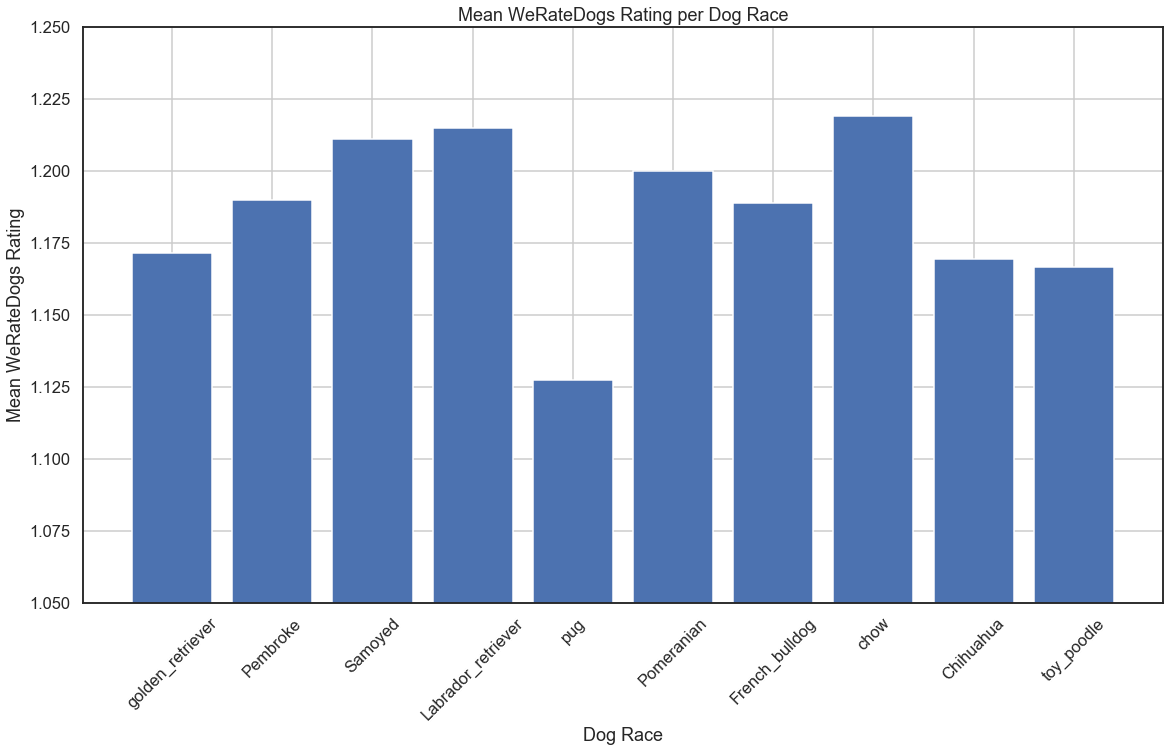

In [1737]:
# Set up the matplotlib figure
#fig = plt.figure(figsize=(15,8))

#ax = fig.add_axes([0,0,1,1])

#ax.bar(races,mean_race_rating)
#degrees = 45
#plt.xticks(rotation=degrees)

#ax.set_ylim([1.05,1.25])
#ax.grid()
#plt.xlabel('Dog Race');
#plt.ylabel('Mean WeRateDogs Rating');
#plt.title('Mean WeRateDogs Rating per Dog Race');
#plt.show()

#fig.savefig('D_MeanWeRateDogsRatingDogRace.png', bbox_inches='tight')
